In [1]:
%run imports.ipynb
%run utility_functions.ipynb
#%run setup.ipynb

2017-01-10 15:06:25.046469 :: AgamP4 reference genome not available


# EQUALLY ACCESSIBLE DIVERSITY STATISTICS - TOTES AMAZE

In [3]:
# Phase 2 data
callset_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/raw/ag1000g.phase2.ar1.h5'
callset = h5py.File(callset_fn, mode='r')
callset_pass_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/pass/ag1000g.phase2.ar1.pass.h5'
callset_pass = h5py.File(callset_pass_fn, mode='r')

accessibility_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/accessibility/accessibility.h5'
accessibility = h5py.File(accessibility_fn, mode='r')

gff_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/geneset/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz'

fasta_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/genome/agamP3/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa'
genome = pyfasta.Fasta(fasta_fn, key_fn=lambda k: k.split()[0])

samples_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/samples/tbl_samples.txt'
df_samples = pandas.read_csv(samples_fn, delimiter='\t')
tbl_samples = etl.fromtsv(samples_fn)
samples = tbl_samples.values('ox_code').list()
subpop_ids = sorted(tbl_samples.values('population').set())
#easier to use pandas here to get index required for subpops dict
subpops = {pid: list(df_samples[df_samples.population == pid].index) for pid in subpop_ids}
subpops['all'] = list(range(len(samples)))

allele_counts_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/allele_counts.h5'
allele_counts = h5py.File(allele_counts_fn, mode='r')

print([(k, len(subpops[k])) for k in sorted(subpops)])

[('AOcol', 78), ('BFcol', 75), ('BFgam', 92), ('CIcol', 71), ('CMgam', 297), ('FRgam', 24), ('GAgam', 69), ('GHcol', 55), ('GHgam', 12), ('GM', 65), ('GNcol', 4), ('GNgam', 40), ('GQgam', 9), ('GW', 91), ('KE', 48), ('UGgam', 112), ('all', 1142)]


In [4]:
def cache_hdf5(path, *names, **h5dcreate_kwargs):
    h5dcreate_kwargs.setdefault('chunks', True)
    h5dcreate_kwargs.setdefault('compression', 'gzip')
    def decorator(f):
        def wrapper(*args, **kwargs):
            result = None

            # be verbose
            verbose = kwargs.pop('verbose', True)
            # don't repeat yourself
            dry = kwargs.pop('dry', True)
            # skip loading if cached
            skip = kwargs.pop('skip', False)
            
            # group name
            grp = '/'.join(map(str, args))
            
            with h5py.File(path, mode='a') as h5f:
                h5g = h5f.require_group(grp)
                
                if dry and '__success__' in h5g.attrs:
                    # no need to build
                    if skip:
                        if verbose:
                            log('skipping', *args)
                    else:
                        if verbose:
                            log('loading', *args)
                        if len(names) == 1:
                            result = h5g[names[0]][:]
                        else:
                            result = [h5g[n][:] for n in names]
                        
                else:
                    # need to build
                    if verbose:
                        log('building', *args)
                    
                    # reset success mark if present
                    if '__success__' in h5g.attrs:
                        del h5g.attrs['__success__']
                        
                    # compute result
                    result = f(*args)
                    
                    if verbose:
                        log('saving', *args)
                    if len(names) == 1:
                        n = names[0]
                        if n in h5g:
                            del h5g[n]
                        h5g.create_dataset(n, data=result, **h5dcreate_kwargs)
                    else:
                        for n, r in zip(names, result):
                            if n in h5g:
                                del h5g[n]
                            h5g.create_dataset(n, data=r, **h5dcreate_kwargs)
                            
                    # mark success
                    h5g.attrs['__success__'] = True

            return result
        return wrapper
    return decorator

# Pi, equally-accessible windows

In [5]:
pi_windows_eqaccess_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/diversity/pi.windows_eqaccess.h5'

@cache_hdf5(pi_windows_eqaccess_fn, 'pi', 'windows', 'n_bases', 'counts')

def pi_windows_eqaccess(window, chrom, pop1):
    # load accessibility
    is_accessible = accessibility[chrom]['is_accessible'][:]
    
    # create equally accessible windows
    pos_accessible = np.nonzero(is_accessible)[0] + 1
    windows = allel.stats.moving_statistic(pos_accessible, lambda v: [v[0], v[-1]], size=window)
    
    # load variant positions
    pos = callset_pass[chrom]['variants']['POS'][:]

    # load raw allele counts
    ac1 = allele_counts[chrom][pop1][:]
    
    #compress raw allele counts
    ps = callset[chrom]['variants']['FILTER_PASS'][:]
    ac = ac1.compress(ps, axis=0)    

    # compute windowed pi
    pi, windows, n_bases, counts = allel.stats.windowed_diversity(pos, ac, size=None,
                                                                    windows=windows,
                                                                    is_accessible=is_accessible)

    return pi, windows, n_bases, counts

In [6]:
for window in 2000, 5000, 10000, 20000:
    for chrom in chromosomes:
        for pop1 in sorted(subpops.keys()) :
            pi_windows_eqaccess(window, chrom, pop1, dry=True, skip=True, verbose=True)

2017-01-10 15:35:20.200685 :: building 2000 2R AOcol
2017-01-10 15:35:46.595377 :: saving 2000 2R AOcol
2017-01-10 15:35:46.725790 :: building 2000 2R BFcol
2017-01-10 15:35:58.058661 :: saving 2000 2R BFcol
2017-01-10 15:35:58.223136 :: building 2000 2R BFgam
2017-01-10 15:36:03.782668 :: saving 2000 2R BFgam
2017-01-10 15:36:03.888445 :: building 2000 2R CIcol
2017-01-10 15:36:13.092588 :: saving 2000 2R CIcol
2017-01-10 15:36:13.200704 :: building 2000 2R CMgam
2017-01-10 15:36:29.788738 :: saving 2000 2R CMgam
2017-01-10 15:36:29.923462 :: building 2000 2R FRgam
2017-01-10 15:36:45.084729 :: saving 2000 2R FRgam
2017-01-10 15:36:45.586851 :: building 2000 2R GAgam
2017-01-10 15:37:10.392468 :: saving 2000 2R GAgam
2017-01-10 15:37:10.510671 :: building 2000 2R GHcol
2017-01-10 15:37:31.419584 :: saving 2000 2R GHcol
2017-01-10 15:37:31.496859 :: building 2000 2R GHgam
2017-01-10 15:37:46.415865 :: saving 2000 2R GHgam
2017-01-10 15:37:46.652088 :: building 2000 2R GM
2017-01-10 15:

In [7]:
for pop1 in sorted(subpops.keys()) :
    print(pop1)

AOcol
BFcol
BFgam
CIcol
CMgam
FRgam
GAgam
GHcol
GHgam
GM
GNcol
GNgam
GQgam
GW
KE
UGgam
all


# Tajima's D, equally accessible windows

In [8]:
tajd_windows_eqaccess_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/diversity/Tajimas_D.windows_eqaccess.h5'

@cache_hdf5(tajd_windows_eqaccess_fn, 'tajd', 'windows', 'counts')

def tajd_windows_eqaccess(window, chrom, pop1):
    # load accessibility
    is_accessible = accessibility[chrom]['is_accessible'][:]
    
    # create equally accessible windows
    pos_accessible = np.nonzero(is_accessible)[0] + 1
    windows = allel.stats.moving_statistic(pos_accessible, lambda v: [v[0], v[-1]], size=window)
    
    # load variant positions
    pos = callset_pass[chrom]['variants']['POS'][:]

    # load raw allele counts
    ac1 = allele_counts[chrom][pop1][:]
    
    # compress raw allele counts
    ps = callset[chrom]['variants']['FILTER_PASS'][:]
    ac = ac1.compress(ps, axis=0)    

    # compute windowed pi
    tajd, windows, counts = allel.stats.windowed_tajima_d(pos, ac, size=None,
                                                                    windows=windows)

    return tajd, windows, counts

In [9]:
for window in 2000, 5000, 10000, 20000:
    for chrom in chromosomes:
        for pop1 in sorted(subpops.keys()) :
            tajd_windows_eqaccess(window, chrom, pop1, dry=True, skip=True, verbose=True)

2017-01-10 18:18:15.929626 :: building 2000 2R AOcol
2017-01-10 18:18:45.066221 :: saving 2000 2R AOcol
2017-01-10 18:18:45.216767 :: building 2000 2R BFcol
2017-01-10 18:18:51.179056 :: saving 2000 2R BFcol
2017-01-10 18:18:52.345696 :: building 2000 2R BFgam
2017-01-10 18:18:59.264443 :: saving 2000 2R BFgam
2017-01-10 18:19:03.899297 :: building 2000 2R CIcol
2017-01-10 18:19:14.655807 :: saving 2000 2R CIcol
2017-01-10 18:19:15.850144 :: building 2000 2R CMgam
2017-01-10 18:19:48.279543 :: saving 2000 2R CMgam
2017-01-10 18:19:48.849792 :: building 2000 2R FRgam
2017-01-10 18:20:18.725127 :: saving 2000 2R FRgam
2017-01-10 18:20:18.828600 :: building 2000 2R GAgam
2017-01-10 18:20:40.592969 :: saving 2000 2R GAgam
2017-01-10 18:20:41.021859 :: building 2000 2R GHcol
2017-01-10 18:21:05.559732 :: saving 2000 2R GHcol
2017-01-10 18:21:06.301515 :: building 2000 2R GHgam
2017-01-10 18:21:27.151870 :: saving 2000 2R GHgam
2017-01-10 18:21:28.144389 :: building 2000 2R GM
2017-01-10 18:

# Watterson's theta, equally accessible windows

In [10]:
theta_windows_eqaccess_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/diversity/theta.windows_eqaccess.h5'

@cache_hdf5(theta_windows_eqaccess_fn, 'theta', 'windows', 'n_bases', 'counts')

def theta_windows_eqaccess(window, chrom, pop1):
    # load accessibility
    is_accessible = accessibility[chrom]['is_accessible'][:]
    
    # create equally accessible windows
    pos_accessible = np.nonzero(is_accessible)[0] + 1
    windows = allel.stats.moving_statistic(pos_accessible, lambda v: [v[0], v[-1]], size=window)
    
    # load variant positions
    pos = callset_pass[chrom]['variants']['POS'][:]

    # load raw allele counts
    ac1 = allele_counts[chrom][pop1][:]
    
    #compress raw allele counts
    ps = callset[chrom]['variants']['FILTER_PASS'][:]
    ac = ac1.compress(ps, axis=0)    

    # compute windowed theta
    theta, windows, n_bases, counts = allel.stats.windowed_watterson_theta(pos, ac, size=None,
                                                                    windows=windows,
                                                                    is_accessible=is_accessible)

    return theta, windows, n_bases, counts

In [11]:
for window in 2000, 5000, 10000, 20000:
    for chrom in chromosomes:
        for pop1 in sorted(subpops.keys()) :
            theta_windows_eqaccess(window, chrom, pop1, dry=True, skip=True, verbose=True)

2017-01-10 19:27:48.401106 :: building 2000 2R AOcol
2017-01-10 19:27:56.456532 :: saving 2000 2R AOcol
2017-01-10 19:27:56.710244 :: building 2000 2R BFcol
2017-01-10 19:28:00.856305 :: saving 2000 2R BFcol
2017-01-10 19:28:01.010440 :: building 2000 2R BFgam
2017-01-10 19:28:05.120810 :: saving 2000 2R BFgam
2017-01-10 19:28:05.259016 :: building 2000 2R CIcol
2017-01-10 19:28:10.597979 :: saving 2000 2R CIcol
2017-01-10 19:28:10.719095 :: building 2000 2R CMgam
2017-01-10 19:28:24.059030 :: saving 2000 2R CMgam
2017-01-10 19:28:24.191969 :: building 2000 2R FRgam
2017-01-10 19:28:34.082670 :: saving 2000 2R FRgam
2017-01-10 19:28:34.264392 :: building 2000 2R GAgam
2017-01-10 19:28:40.447309 :: saving 2000 2R GAgam
2017-01-10 19:28:40.612726 :: building 2000 2R GHcol
2017-01-10 19:28:46.221237 :: saving 2000 2R GHcol
2017-01-10 19:28:46.430695 :: building 2000 2R GHgam
2017-01-10 19:28:50.875882 :: saving 2000 2R GHgam
2017-01-10 19:28:50.985244 :: building 2000 2R GM
2017-01-10 19:

# Dxy, equally-accessible windows

In [12]:
dxy_windows_eqaccess_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/diversity/dxy.windows_eqaccess.h5'


@cache_hdf5(dxy_windows_eqaccess_fn, 'dxy', 'windows', 'n_bases', 'counts')
def dxy_windows_eqaccess(window, chrom, pop1, pop2):

    # load accessibility
    is_accessible = accessibility[chrom]['is_accessible'][:]
    
    # create equally accessible windows
    pos_accessible = np.nonzero(is_accessible)[0] + 1
    windows = allel.stats.moving_statistic(pos_accessible, lambda v: [v[0], v[-1]], size=window)
    
    # load variant positions
    pos = callset_pass[chrom]['variants']['POS'][:]

    # load raw allele counts
    ac1 = allele_counts[chrom][pop1][:]
    ac2 = allele_counts[chrom][pop1][:]
    
    #compress raw allele counts
    ps = callset[chrom]['variants']['FILTER_PASS'][:]
    ac11 = ac1.compress(ps, axis=0) 
    ac22 = ac2.compress(ps, axis=0)

    # compute windowed pi
    dxy, windows, n_bases, counts = allel.stats.windowed_divergence(pos, ac11, ac22, size=None,
                                                                    windows=windows,
                                                                    is_accessible=is_accessible)

    return dxy, windows, n_bases, counts

In [13]:
for window in 2000, 5000, 10000, 20000:
    for chrom in chromosomes:
        for (pop1, pop2) in [('BFgam', 'BFcol'), ('GAgam', 'AOcol')]:
            dxy_windows_eqaccess(window, chrom, pop1, pop2, dry=True, skip=True, verbose=True)


2017-01-10 19:56:50.528010 :: building 2000 2R BFgam BFcol
2017-01-10 19:57:02.336420 :: saving 2000 2R BFgam BFcol
2017-01-10 19:57:02.460703 :: building 2000 2R GAgam AOcol
2017-01-10 19:57:15.393598 :: saving 2000 2R GAgam AOcol
2017-01-10 19:57:15.488859 :: building 2000 2L BFgam BFcol
2017-01-10 19:57:24.504625 :: saving 2000 2L BFgam BFcol
2017-01-10 19:57:24.694403 :: building 2000 2L GAgam AOcol
2017-01-10 19:57:32.619126 :: saving 2000 2L GAgam AOcol
2017-01-10 19:57:32.751776 :: building 2000 3R BFgam BFcol
2017-01-10 19:57:43.864733 :: saving 2000 3R BFgam BFcol
2017-01-10 19:57:43.983802 :: building 2000 3R GAgam AOcol
2017-01-10 19:57:53.674311 :: saving 2000 3R GAgam AOcol
2017-01-10 19:57:53.786103 :: building 2000 3L BFgam BFcol
2017-01-10 19:58:01.526044 :: saving 2000 3L BFgam BFcol
2017-01-10 19:58:01.606795 :: building 2000 3L GAgam AOcol
2017-01-10 19:58:08.456905 :: saving 2000 3L GAgam AOcol
2017-01-10 19:58:08.578402 :: building 2000 X BFgam BFcol
2017-01-10 19:

In [14]:
sorted(subpops.keys())

['AOcol',
 'BFcol',
 'BFgam',
 'CIcol',
 'CMgam',
 'FRgam',
 'GAgam',
 'GHcol',
 'GHgam',
 'GM',
 'GNcol',
 'GNgam',
 'GQgam',
 'GW',
 'KE',
 'UGgam',
 'all']

# PANOPTES

In [17]:
fn_template = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/panoptes/windows_eqaccess.{window}.{chrom}.txt'


def build_df(chrom, window='10000'):

    # pi
    pi_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/diversity/pi.windows_eqaccess.h5'
    pi = h5py.File(pi_fn, mode='r')

    # tajima's D
    tjd_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/diversity/Tajimas_D.windows_eqaccess.h5'
    tjd = h5py.File(tjd_fn, mode='r')

    # Dxy
    dxy_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/extras/diversity/dxy.windows_eqaccess.h5'
    dxy = h5py.File(dxy_fn, mode='r')

    pops = ['AOcol','BFcol','BFgam','CIcol','CMgam','FRgam','GAgam','GHcol','GHgam','GM', 'GNcol','GNgam','GQgam','GW','KE','UGgam']
    
    pig = pi[window][chrom]['AOcol']
    # N.B., previous data includes final odd-size window, remove here
    windows = pig['windows'][:-1]
    starts = windows[:, 0]
    stops = windows[:, 1]
    midpoints = np.round(windows.mean(axis=1))
    items = [
        ('chrom', [chrom] * len(starts)),
        ('start', starts),
        ('stop', stops),
        ('midpoint', midpoints),
    ]
    
    for pop in pops:
        x = pi[window][chrom][pop]['pi'][:-1]
        items.append(('pi_' + pop, x))

    for pop in pops:
        y = tjd[window][chrom][pop]['tajd'][:-1]
        items.append(('tajima_d_' + pop, y))
    
    for pop1, pop2 in [('BFgam', 'BFcol'), ('GAgam', 'AOcol')]:
        z = dxy[window][chrom][pop1][pop2]['dxy'][:-1]
        items.append(('dxy_' + pop1 + '_' + pop2, z))

    df = pandas.DataFrame.from_items(items)

    fn = fn_template.format(window=window, chrom=chrom)
    df.to_csv(fn, sep='\t', index=False)
    
    return df



In [35]:
df = build_df('2L')
df.head()

,chrom,start,stop,midpoint,pi_AOcol,pi_BFcol,pi_BFgam,pi_CIcol,pi_CMgam,pi_FRgam,...,tajima_d_GHgam,tajima_d_GM,tajima_d_GNcol,tajima_d_GNgam,tajima_d_GQgam,tajima_d_GW,tajima_d_KE,tajima_d_UGgam,dxy_BFgam_BFcol,dxy_GAgam_AOcol
0,2L,25044,186952,105998.0,0.002442,0.003008,0.000232,0.002280,0.001367,0.000875,...,-1.228292,-0.083194,-1.907898,-2.478386,-0.916530,-0.742047,1.729681,-1.268868,0.000231,0.000934
1,2L,186953,371051,279002.0,0.001701,0.002278,0.000205,0.001781,0.000815,0.001133,...,-1.343970,-0.245128,-1.897972,-2.368393,-0.985176,-1.109672,0.827157,-0.876525,0.000204,0.000637
2,2L,371052,464688,417870.0,0.002389,0.003129,0.000296,0.002271,0.000999,0.001221,...,-1.458834,0.521731,-1.901593,-1.693052,-1.399058,-0.737653,1.007264,-1.324321,0.000295,0.000810
3,2L,464689,528798,496744.0,0.001476,0.002263,0.000265,0.001607,0.000837,0.000907,...,-1.088285,0.017620,-1.893526,-1.911331,-1.359485,-1.040062,1.341552,-0.778528,0.000264,0.000579
4,2L,528799,640610,584704.0,0.002181,0.002401,0.000222,0.001891,0.000923,0.001702,...,-1.484571,-0.414603,-1.898626,-2.256373,-1.215339,-1.152255,1.474406,-0.858689,0.000221,0.000882


In [19]:
df = build_df('2R')
df.head()

,chrom,start,stop,midpoint,pi_AOcol,pi_BFcol,pi_BFgam,pi_CIcol,pi_CMgam,pi_FRgam,...,tajima_d_GHgam,tajima_d_GM,tajima_d_GNcol,tajima_d_GNgam,tajima_d_GQgam,tajima_d_GW,tajima_d_KE,tajima_d_UGgam,dxy_BFgam_BFcol,dxy_GAgam_AOcol
0,2R,1434,22185,11810.0,0.001797,0.002057,0.001991,0.002166,0.002034,0.002092,...,-0.794690,-1.654773,-0.915543,-2.093068,-1.149166,-2.128522,1.779247,-2.300857,0.001980,0.001540
1,2R,22186,36399,29292.0,0.001465,0.001599,0.001595,0.001823,0.001622,0.002245,...,-1.254845,-1.744284,-0.380120,-2.225192,-0.970011,-2.048638,1.573761,-2.399860,0.001586,0.001287
2,2R,36400,53338,44869.0,0.002787,0.002848,0.002720,0.003128,0.002658,0.003282,...,-0.799243,-1.399070,1.061115,-2.153924,-0.994663,-1.947888,2.002510,-2.294104,0.002705,0.002447
3,2R,53339,69113,61226.0,0.001638,0.002060,0.001938,0.002000,0.001943,0.003083,...,-1.233023,-1.805196,0.744121,-2.275222,-1.396974,-2.171312,1.193667,-2.393084,0.001927,0.002097
4,2R,69114,83816,76465.0,0.001872,0.002268,0.002356,0.002250,0.002392,0.001920,...,-1.092706,-1.257802,0.489141,-1.748317,-0.358039,-1.712198,2.679355,-2.021693,0.002343,0.001840


In [31]:
df = build_df('3L')
df.head()

,chrom,start,stop,midpoint,pi_AOcol,pi_BFcol,pi_BFgam,pi_CIcol,pi_CMgam,pi_FRgam,...,tajima_d_GHgam,tajima_d_GM,tajima_d_GNcol,tajima_d_GNgam,tajima_d_GQgam,tajima_d_GW,tajima_d_KE,tajima_d_UGgam,dxy_BFgam_BFcol,dxy_GAgam_AOcol
0,3L,9779,81690,45734.0,0.001109,0.000874,0.001692,0.000771,0.001095,0.000659,...,-1.391980,-0.003096,-1.112144,-1.743166,-2.093478,-0.739998,3.696198,-2.172272,0.001683,0.002203
1,3L,81691,137975,109833.0,0.001048,0.000825,0.001778,0.000821,0.001380,0.000978,...,-1.296486,0.406279,-0.915596,-1.814154,-1.938269,-0.751218,3.065689,-2.035174,0.001769,0.002184
2,3L,137976,182899,160438.0,0.001385,0.000872,0.002520,0.000933,0.002088,0.001757,...,-0.775221,0.687454,-1.365337,-1.339141,-1.392526,-0.839440,2.834624,-1.575099,0.002507,0.003090
3,3L,182900,295142,239021.0,0.001753,0.001050,0.002196,0.001157,0.001751,0.001569,...,-1.057694,-0.050671,-0.931617,-1.393578,-1.409521,-0.677041,2.691582,-1.812344,0.002184,0.002572
4,3L,295143,339868,317506.0,0.000699,0.001011,0.001481,0.001106,0.001091,0.000726,...,-1.328885,0.083754,0.881098,-1.996479,-1.699541,-0.591537,3.069006,-2.057159,0.001473,0.001922


In [43]:
df = build_df('3R')
df.head()

,chrom,start,stop,midpoint,pi_AOcol,pi_BFcol,pi_BFgam,pi_CIcol,pi_CMgam,pi_FRgam,...,tajima_d_GHgam,tajima_d_GM,tajima_d_GNcol,tajima_d_GNgam,tajima_d_GQgam,tajima_d_GW,tajima_d_KE,tajima_d_UGgam,dxy_BFgam_BFcol,dxy_GAgam_AOcol
0,3R,21,23622,11822.0,0.000650,0.001448,0.001682,0.001467,0.001747,0.000847,...,-1.633688,-0.144646,-0.762044,-2.322562,-1.586041,-0.605406,-0.763015,-2.329977,0.001672,0.001743
1,3R,23623,34020,28822.0,0.000986,0.002052,0.002274,0.001997,0.002385,0.001254,...,-1.984818,-0.076193,-0.818163,-2.371961,-1.243079,-0.543234,-1.067267,-2.043637,0.002262,0.002839
2,3R,34021,44106,39064.0,0.000596,0.001825,0.001974,0.001966,0.001879,0.000761,...,-1.944800,-0.240138,-0.283584,-2.289905,-1.564853,-0.719157,-0.510617,-2.414824,0.001964,0.001271
3,3R,44107,55753,49930.0,0.000858,0.002917,0.003157,0.003637,0.003088,0.001686,...,-1.259583,-0.328687,-0.148236,-1.971725,-1.285866,-0.847110,-0.710739,-2.122377,0.003140,0.002565
4,3R,55754,65901,60828.0,0.000571,0.002865,0.003653,0.003083,0.003716,0.002960,...,-1.167630,0.307191,-1.145459,-1.846467,-1.218007,-0.258811,-0.572822,-1.972126,0.003633,0.003431


In [42]:
df = build_df('X')
df.head()

,chrom,start,stop,midpoint,pi_AOcol,pi_BFcol,pi_BFgam,pi_CIcol,pi_CMgam,pi_FRgam,...,tajima_d_GHgam,tajima_d_GM,tajima_d_GNcol,tajima_d_GNgam,tajima_d_GQgam,tajima_d_GW,tajima_d_KE,tajima_d_UGgam,dxy_BFgam_BFcol,dxy_GAgam_AOcol
0,X,36,15863,7950.0,0.000537,0.000847,0.000933,0.001005,0.000917,0.000060,...,-1.675891,-2.082789,-0.738338,-2.378788,0.057766,-2.156483,2.231857,-2.290685,0.000926,0.000405
1,X,15864,30193,23028.0,0.000624,0.000966,0.001062,0.001605,0.001060,0.000120,...,-1.918150,-2.122186,-0.499356,-2.388421,0.091386,-2.103936,1.323618,-2.245737,0.001054,0.000316
2,X,30194,42720,36457.0,0.000635,0.000767,0.001199,0.001299,0.001255,0.000164,...,-0.983147,-2.124144,-0.107259,-2.087155,0.207510,-2.047520,1.593675,-2.112379,0.001190,0.000465
3,X,42721,54763,48742.0,0.000747,0.001025,0.001706,0.001422,0.001715,0.000060,...,-1.298242,-2.082229,-0.142599,-1.824567,-0.525512,-1.946376,0.877225,-1.814159,0.001694,0.000765
4,X,54764,71116,62940.0,0.001017,0.001874,0.002675,0.002044,0.002513,0.000024,...,-1.133446,-1.714036,-0.277425,-1.770052,-0.290484,-1.535512,1.897368,-1.756663,0.002655,0.001117


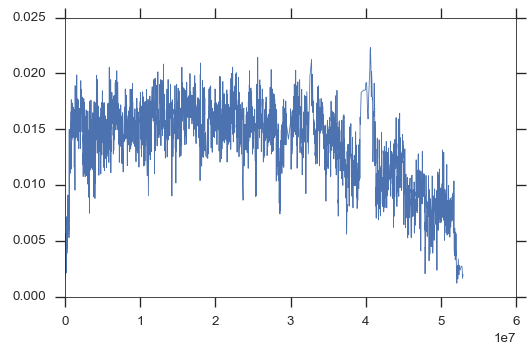

In [44]:
plt.plot(df.midpoint, df.dxy_BFgam_BFcol);

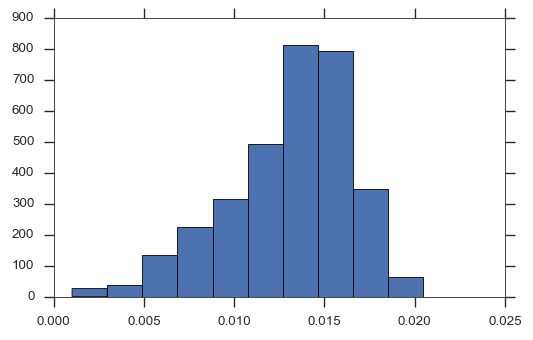

In [45]:
plt.hist(df.pi_GHcol);



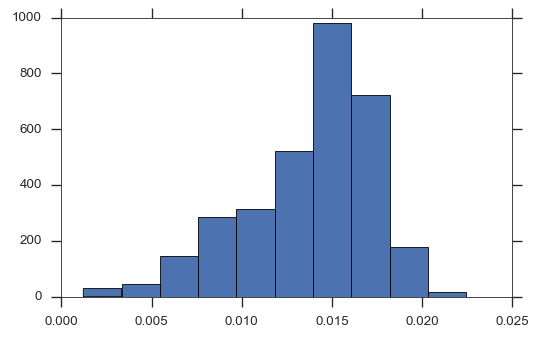

In [46]:
plt.hist(df.pi_BFgam);

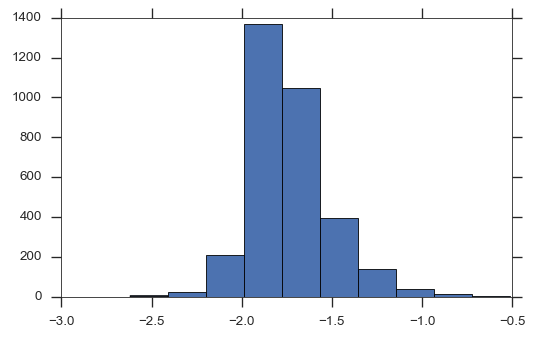

In [47]:
plt.hist(df.tajima_d_BFcol);

In [48]:
tbls = [etl.fromtsv(fn_template.format(window='10000', chrom=chrom)) for chrom in sorted(chromosomes)]
tbls[0]

0|chrom,1|start,2|stop,3|midpoint,4|pi_AOcol,5|pi_BFcol,6|pi_BFgam,7|pi_CIcol,8|pi_CMgam,9|pi_FRgam,10|pi_GAgam,11|pi_GHcol,12|pi_GHgam,13|pi_GM,14|pi_GNcol,15|pi_GNgam,16|pi_GQgam,17|pi_GW,18|pi_KE,19|pi_UGgam,20|tajima_d_AOcol,21|tajima_d_BFcol,22|tajima_d_BFgam,23|tajima_d_CIcol,24|tajima_d_CMgam,25|tajima_d_FRgam,26|tajima_d_GAgam,27|tajima_d_GHcol,28|tajima_d_GHgam,29|tajima_d_GM,30|tajima_d_GNcol,31|tajima_d_GNgam,32|tajima_d_GQgam,33|tajima_d_GW,34|tajima_d_KE,35|tajima_d_UGgam,36|dxy_BFgam_BFcol,37|dxy_GAgam_AOcol
2L,25044,186952,105998.0,0.0024420215731980437,0.0030079552572706936,0.00023234735091470657,0.0022797722505244226,0.0013668631630296168,0.0008747340425531913,0.0009408654893248954,0.00289581317764804,0.0004670289855072463,0.0053567741317805985,0.001925,0.00010221518987341774,0.002730065359477124,0.00574213236247732,0.002760811403508772,0.0007374679692504804,-0.16916551668036,0.018907527232425038,-2.393644324806807,-0.5862316549046023,-2.1107919838756772,-0.6018895586967168,-1.7525271231854362,0.1280139087888578,-1.2282922926517366,-0.08319370798387532,-1.9078980333252624,-2.4783858767234523,-0.9165300292399831,-0.7420467599402322,1.7296809530879933,-1.2688677018523922,0.00023108459357277882,0.0009340474667479208
2L,186953,371051,279002.0,0.0017010371938834935,0.0022783882671878835,0.00020463886909004514,0.0017809010088902205,0.0008147171544873614,0.0011327127659574467,0.0006411826933248704,0.002501968306922435,0.0003739130434782609,0.004218293056475052,0.001425,0.00016579113924050632,0.0018,0.004127172046218449,0.0020233552631578945,0.0009990631005765537,0.09025299462639651,-0.20651485306760667,-2.187777639320116,-0.888458482037102,-2.441477865644666,-0.3573529770970464,-2.0675973429195436,0.4825738575140933,-1.3439696226664224,-0.2451283364722061,-1.897971662207408,-2.368393190787388,-0.9851756382338978,-1.1096715675009474,0.8271567450944912,-0.8765252218153096,0.00020352670132325144,0.0006365364419239656
2L,371052,464688,417870.0,0.0023890321211573586,0.003128948545861298,0.0002961689237348539,0.0022711417440815103,0.0009994753606895259,0.0012210910679412066,0.0008159526076377869,0.002959482902418682,0.00033840579710144925,0.004176374478234943,0.001575,0.00021553797468354432,0.0022326797385620913,0.004226171254249281,0.001986118421052632,0.0006260175272849091,0.7023127459501035,0.45686309441563683,-2.0757362046804797,-0.26839644008939356,-2.258114751991336,-0.629673923061989,-1.7453377023965742,1.4124238095811907,-1.4588339952307334,0.5217312889923532,-1.9015933160764866,-1.6930524431895109,-1.3990584494892526,-0.7376531686273559,1.007263680055049,-1.324321233288046,0.0002945593100189036,0.0008100399075824405
2L,464689,528798,496744.0,0.001475643464694698,0.002263498881431767,0.0002652886671418389,0.0016066726600739187,0.0008371545698695783,0.0009070921985815602,0.0005834655664868295,0.0022442175968146985,0.0003952898550724638,0.003363064997018485,0.001275,0.00018085443037974683,0.0017281045751633985,0.0034859118060932928,0.001924561403508772,0.0007533961643668951,-0.10995760209589985,-0.5235940463127099,-1.9817166011071181,-0.8722124498749113,-2.32647900434451,-0.6186345952285994,-1.8593631526489707,0.28036156625518116,-1.0882850105567405,0.017619647453209517,-1.8935262937828938,-1.9113310342604974,-1.3594849443670134,-1.0400624144379913,1.341552175752502,-0.7785282205932711,0.0002638468809073724,0.0005792375551354757
2L,528799,640610,584704.0,0.0021805588971433375,0.0024006227369225606,0.00022239843193157518,0.0018911797023274395,0.0009227190095143999,0.0017015070921985818,0.0008881201734898974,0.002622835696413678,0.00041920289855072463,0.005078187239117472,0.00145,0.00014712025316455696,0.0020869281045751632,0.005240581931283279,0.0022307894736842107,0.0009094530749519539,-0.22651419768736253,-0.7689538334222417,-2.2044434340641326,-1.2347246324132368,-2.376731665283004,0.22436423610195763,-1.97176508912635,0.18352458132584215,-1.484570915319743,-0.414603006668914,-1.8986257725740372,-2.256372853233694,

In [49]:
tbls[-1]

0|chrom,1|start,2|stop,3|midpoint,4|pi_AOcol,5|pi_BFcol,6|pi_BFgam,7|pi_CIcol,8|pi_CMgam,9|pi_FRgam,10|pi_GAgam,11|pi_GHcol,12|pi_GHgam,13|pi_GM,14|pi_GNcol,15|pi_GNgam,16|pi_GQgam,17|pi_GW,18|pi_KE,19|pi_UGgam,20|tajima_d_AOcol,21|tajima_d_BFcol,22|tajima_d_BFgam,23|tajima_d_CIcol,24|tajima_d_CMgam,25|tajima_d_FRgam,26|tajima_d_GAgam,27|tajima_d_GHcol,28|tajima_d_GHgam,29|tajima_d_GM,30|tajima_d_GNcol,31|tajima_d_GNgam,32|tajima_d_GQgam,33|tajima_d_GW,34|tajima_d_KE,35|tajima_d_UGgam,36|dxy_BFgam_BFcol,37|dxy_GAgam_AOcol
X,36,15863,7950.0,0.0005367910584039617,0.0008467560217560217,0.0009329031534059027,0.0010054639896114274,0.0009173059914687119,6.014492753623189e-05,0.00040807151168941076,0.0011157964970809008,0.0009177536231884058,0.0006874299344066786,0.0006285714285714285,0.0009010443037974683,0.0010026143790849674,0.0009259001342426757,0.001139364035087719,0.0008439943066064142,-0.6728830078330145,-2.1396416843742037,-2.475332017436482,-1.3387261290929997,-2.534105962236336,0.2704626266749478,-1.2308123201061658,-1.3620103329662683,-1.675891419387138,-2.082788836669949,-0.7383379147893414,-2.3787883297307166,0.05776645187517416,-2.156483323573545,2.2318571083295304,-2.2906847606511813,0.0009259411895745155,0.00040511447174963234
X,15864,30193,23028.0,0.0006241191066997519,0.0009657634032634033,0.0010616204690831557,0.0016045450004994503,0.001059954604156068,0.00012028985507246375,0.00031851264148947424,0.0015143619683069226,0.0009735507246376812,0.0007843053070960047,0.0013285714285714285,0.00102,0.0010405228758169933,0.001273978507680165,0.00108015350877193,0.0010495624342844732,-1.3085547905870007,-2.0494021995315226,-2.5401006322907764,-0.8557871424646593,-2.538594203722027,0.3363728051666992,-1.8922310495535306,-1.3453731883381184,-1.918150255165598,-2.1221857648898514,-0.4993560865917408,-2.388421228370924,0.09138645402420792,-2.103936071062345,1.323617793568196,-2.2457367926190743,0.0010536979282691024,0.0003162045788699853
X,30194,42720,36457.0,0.0006347064763193795,0.0007674048174048175,0.0011986196835372014,0.0012992979634016148,0.0012551183814033578,0.000163768115942029,0.00046806304876758704,0.0009692743953294413,0.001121376811594203,0.0006690915741692843,0.0011714285714285715,0.0012542721518987343,0.0013745098039215685,0.0010636998360755267,0.0010028508771929825,0.0012397221332479179,-0.6234907710148536,-2.2626767543649353,-2.297384361296782,-1.1091553278997632,-2.332615755291038,1.4464654933270285,-1.12632308839154,-1.7077362523346415,-0.9831469233461054,-2.1241436002262892,-0.10725912877672528,-2.0871550012994637,0.20751012639500843,-2.0475203326294786,1.5936745796860645,-2.112378902449977,0.0011896747605257296,0.0004646712875446335
X,42721,54763,48742.0,0.0007465756823821338,0.0010253690753690753,0.0017064192026878594,0.001421943253993064,0.0017150714201854967,6.014492753623189e-05,0.0007706653972283931,0.00125511259382819,0.0015648550724637683,0.0009925939177101968,0.0016142857142857142,0.0018207911392405067,0.001625294117647059,0.0015978021978021977,0.0010698030981709592,0.0016630201721058355,-0.7242605766688643,-2.2226586776256765,-2.1822883849320562,-1.1235021857499492,-2.3813901921163523,0.2704626266749478,-1.0881617844196336,-1.6016878644012214,-1.2982420563862918,-2.082229102187227,-0.14259880521054177,-1.8245665423029263,-0.525512139562038,-1.9463764645573973,0.8772252042165577,-1.8141592123771328,0.0016936845597062997,0.0007650808653644192
X,54764,71116,62940.0,0.001017328370554177,0.0018742812742812746,0.0026752665245202557,0.002044261312556188,0.00251256291157066,2.4275362318840576e-05,0.001125494551994076,0.002203569641367807,0.0028202898550724635,0.0017612760882528323,0.0029642857142857144,0.0027086392405063294,0.0023810457516339864,0.0027355716107097324,0.0021270394736842106,0.0023094588608301827,-0.8912230367413432,-1.7309926896865278,-1.9750932897399713,-1.0328996443793126,-2.119627374559401,-1.2022892024662681,-1.1753199027962637,-0.6737423259054189,-1.1334464469497811,-1.7140362535841496

In [50]:
tbl = etl.cat(*tbls)
tbl

0|chrom,1|start,2|stop,3|midpoint,4|pi_AOcol,5|pi_BFcol,6|pi_BFgam,7|pi_CIcol,8|pi_CMgam,9|pi_FRgam,10|pi_GAgam,11|pi_GHcol,12|pi_GHgam,13|pi_GM,14|pi_GNcol,15|pi_GNgam,16|pi_GQgam,17|pi_GW,18|pi_KE,19|pi_UGgam,20|tajima_d_AOcol,21|tajima_d_BFcol,22|tajima_d_BFgam,23|tajima_d_CIcol,24|tajima_d_CMgam,25|tajima_d_FRgam,26|tajima_d_GAgam,27|tajima_d_GHcol,28|tajima_d_GHgam,29|tajima_d_GM,30|tajima_d_GNcol,31|tajima_d_GNgam,32|tajima_d_GQgam,33|tajima_d_GW,34|tajima_d_KE,35|tajima_d_UGgam,36|dxy_BFgam_BFcol,37|dxy_GAgam_AOcol
2L,25044,186952,105998.0,0.0024420215731980437,0.0030079552572706936,0.00023234735091470657,0.0022797722505244226,0.0013668631630296168,0.0008747340425531913,0.0009408654893248954,0.00289581317764804,0.0004670289855072463,0.0053567741317805985,0.001925,0.00010221518987341774,0.002730065359477124,0.00574213236247732,0.002760811403508772,0.0007374679692504804,-0.16916551668036,0.018907527232425038,-2.393644324806807,-0.5862316549046023,-2.1107919838756772,-0.6018895586967168,-1.7525271231854362,0.1280139087888578,-1.2282922926517366,-0.08319370798387532,-1.9078980333252624,-2.4783858767234523,-0.9165300292399831,-0.7420467599402322,1.7296809530879933,-1.2688677018523922,0.00023108459357277882,0.0009340474667479208
2L,186953,371051,279002.0,0.0017010371938834935,0.0022783882671878835,0.00020463886909004514,0.0017809010088902205,0.0008147171544873614,0.0011327127659574467,0.0006411826933248704,0.002501968306922435,0.0003739130434782609,0.004218293056475052,0.001425,0.00016579113924050632,0.0018,0.004127172046218449,0.0020233552631578945,0.0009990631005765537,0.09025299462639651,-0.20651485306760667,-2.187777639320116,-0.888458482037102,-2.441477865644666,-0.3573529770970464,-2.0675973429195436,0.4825738575140933,-1.3439696226664224,-0.2451283364722061,-1.897971662207408,-2.368393190787388,-0.9851756382338978,-1.1096715675009474,0.8271567450944912,-0.8765252218153096,0.00020352670132325144,0.0006365364419239656
2L,371052,464688,417870.0,0.0023890321211573586,0.003128948545861298,0.0002961689237348539,0.0022711417440815103,0.0009994753606895259,0.0012210910679412066,0.0008159526076377869,0.002959482902418682,0.00033840579710144925,0.004176374478234943,0.001575,0.00021553797468354432,0.0022326797385620913,0.004226171254249281,0.001986118421052632,0.0006260175272849091,0.7023127459501035,0.45686309441563683,-2.0757362046804797,-0.26839644008939356,-2.258114751991336,-0.629673923061989,-1.7453377023965742,1.4124238095811907,-1.4588339952307334,0.5217312889923532,-1.9015933160764866,-1.6930524431895109,-1.3990584494892526,-0.7376531686273559,1.007263680055049,-1.324321233288046,0.0002945593100189036,0.0008100399075824405
2L,464689,528798,496744.0,0.001475643464694698,0.002263498881431767,0.0002652886671418389,0.0016066726600739187,0.0008371545698695783,0.0009070921985815602,0.0005834655664868295,0.0022442175968146985,0.0003952898550724638,0.003363064997018485,0.001275,0.00018085443037974683,0.0017281045751633985,0.0034859118060932928,0.001924561403508772,0.0007533961643668951,-0.10995760209589985,-0.5235940463127099,-1.9817166011071181,-0.8722124498749113,-2.32647900434451,-0.6186345952285994,-1.8593631526489707,0.28036156625518116,-1.0882850105567405,0.017619647453209517,-1.8935262937828938,-1.9113310342604974,-1.3594849443670134,-1.0400624144379913,1.341552175752502,-0.7785282205932711,0.0002638468809073724,0.0005792375551354757
2L,528799,640610,584704.0,0.0021805588971433375,0.0024006227369225606,0.00022239843193157518,0.0018911797023274395,0.0009227190095143999,0.0017015070921985818,0.0008881201734898974,0.002622835696413678,0.00041920289855072463,0.005078187239117472,0.00145,0.00014712025316455696,0.0020869281045751632,0.005240581931283279,0.0022307894736842107,0.0009094530749519539,-0.22651419768736253,-0.7689538334222417,-2.2044434340641326,-1.2347246324132368,-2.376731665283004,0.22436423610195763,-1.97176508912635,0.18352458132584215,-1.484570915319743,-0.414603006668914,-1.8986257725740372,-2.256372853233694,

In [51]:
tbl.totsv(fn_template.format(window='10000', chrom='all'))